# Assessment of the quality of X-mask_atlas-corrected

In [1]:
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import resample_img
import os
from scipy.ndimage.morphology import binary_erosion

import seaborn as sbs

import pickle

In [2]:
# Function that takes dictionary and model and returns Sorensen-Dice coefficients for target-prediction pairs

# Sorensen-Dice coefficient
def dice(img_true, img_pred, smooth=0):       
    intersection = np.sum(img_true * img_pred)
    union = np.sum(img_true) + np.sum(img_pred)
    dice = (2. * intersection + smooth)/(union+smooth)   
    return dice
                    
def calculate_dice(path1, path2):
    file_target, file_prediction = nib.load(path1), nib.load(path2)   
    file_target_trans, file_prediction_trans = resample_img(file_target, file_prediction.affine, file_prediction.shape, 'linear'),resample_img(file_prediction, file_prediction.affine, file_prediction.shape, 'linear')       
    data_target, data_prediction = file_target_trans.get_fdata(), file_prediction_trans.get_fdata()
    return dice(data_target, data_prediction)

In [3]:
# Groups
groups=['HCP','CHIASM']

# Participants
CHIASM_con=['CON1','CON2','CON3','CON4','CON5','CON6','CON7','CON8']
CHIASM_alb=['ALB1','ALB2','ALB3','ALB4','ALB5','ALB6','ALB7','ALB8','ALB9']
HCP_con= ['101107','118730','131823','134223','151425','165436','208226','304727','379657','673455']

# Path to data
data_folder='../../1_Data/'

In [4]:
dice_hand_vs_initial={}

for group in groups:
    dice_hand_vs_initial[group]={}
    for sub in eval(group+'_con'):
        hand=data_folder+'2_X-mask_manual/'+group+'/'+sub+'/X-mask_manual.nii.gz'
        label=data_folder+'3_X-mask_atlas-initial/'+group+'/'+sub+'/X-mask_atlas-initial_cropped_to_gt.nii.gz'    
        dice_hand_vs_initial[group][sub]=calculate_dice(hand,label)

In [5]:
dice_hand_vs_refined={}

for group in groups:
    dice_hand_vs_refined[group]={}
    for sub in eval(group+'_con'):
        hand=data_folder+'2_X-mask_manual/'+group+'/'+sub+'/X-mask_manual.nii.gz'
        label=data_folder+'4_X-mask_atlas-corrected/'+group+'/'+sub+'/X-mask_atlas-corrected_cropped_to_gt.nii.gz'    
        dice_hand_vs_refined[group][sub]=calculate_dice(hand,label)

In [6]:
# Dictionary of colors
color_dict={}
color_dict['HCP']="#648FFF"
color_dict['CHIASM']='#DC267F'
color_dict['CHIASM']='#FFB000'

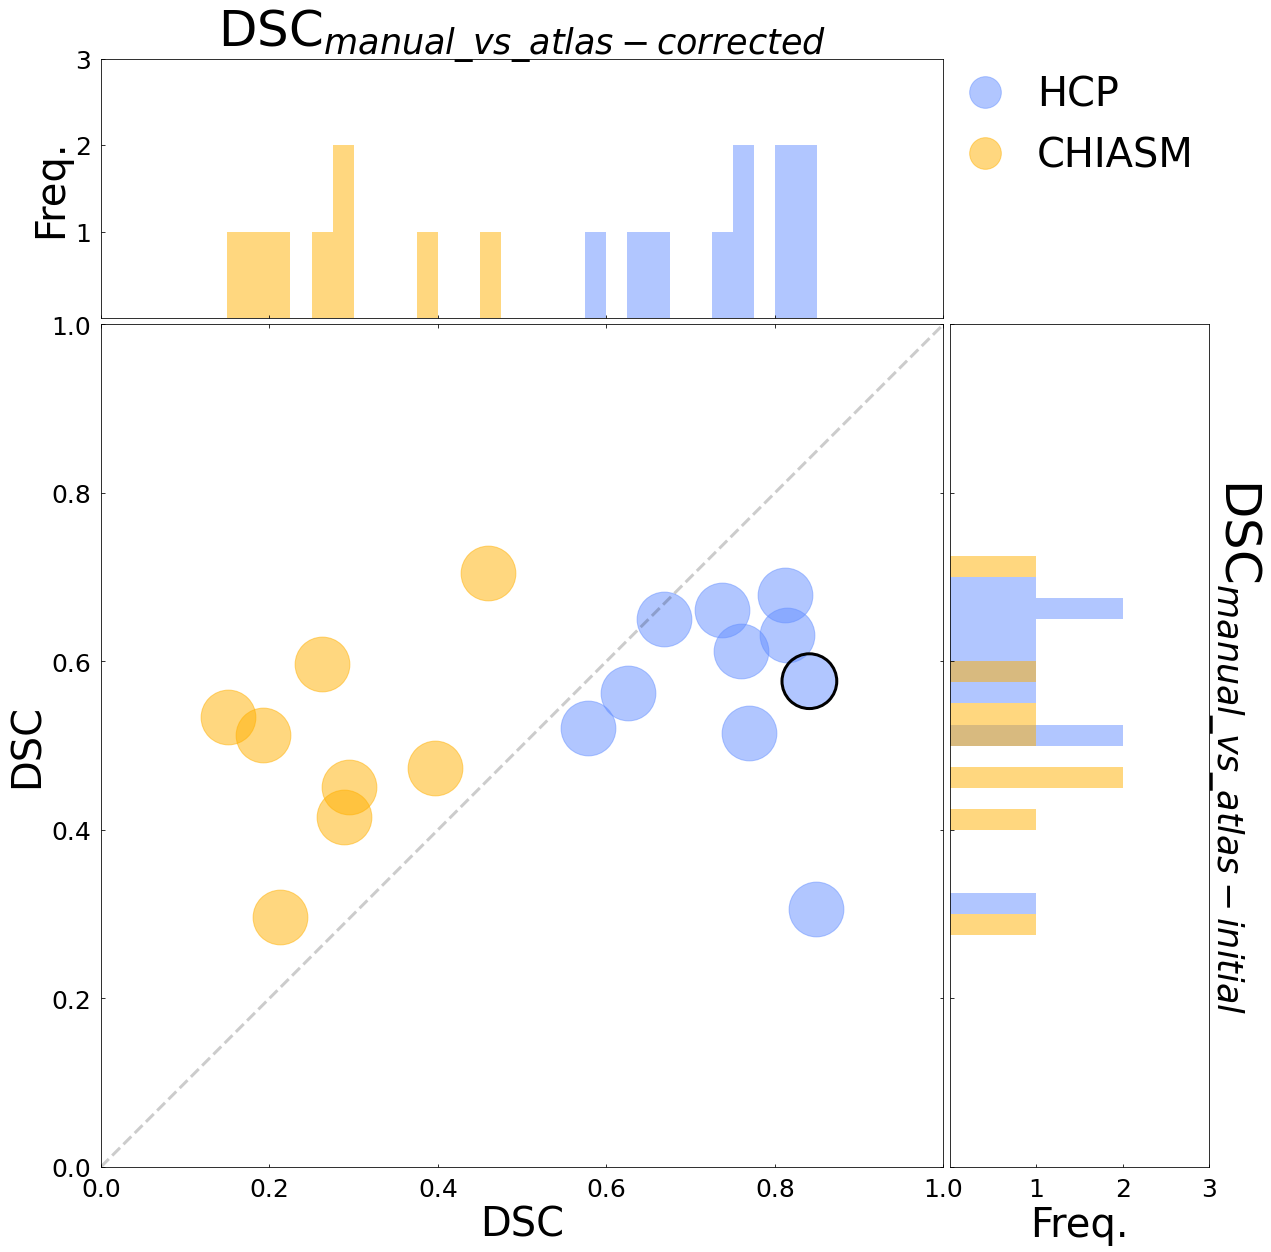

In [22]:
# Plot DICE for HCP
#group=['HCP']

# Adjusting shape of the figure
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# Rectangular scatter plot settings
plt.figure(figsize=(18, 18))

title_font_size= 50
legend_font_size= 40
axes_font_size= 25

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# Scatter plot:
for g in groups:
    ax_scatter.scatter(list(dice_hand_vs_refined[g].values()),list(dice_hand_vs_initial[g].values()),s=3000,alpha=0.5, label=g, color=color_dict[g])

# Mark chosen datasets
ax_scatter.scatter(dice_hand_vs_refined['HCP']['304727'],dice_hand_vs_initial['HCP']['304727'],s=3000, facecolors='none', edgecolors='k', linewidth=3)
   
ax_scatter.plot(np.linspace(0,1),np.linspace(0,1), linestyle='--', color='black', alpha=0.2, linewidth=3)

lgnd = ax_scatter.legend(loc='upper right', bbox_to_anchor=(1.34,1.34), fontsize=legend_font_size,handlelength=1.0, handleheight=1., framealpha=0)

lgnd.legendHandles[0]._sizes = [1000]
lgnd.legendHandles[1]._sizes = [1000]

ax_scatter.tick_params(axis='both', labelsize=axes_font_size, pad=10)

ax_scatter.set_xlabel('DSC', fontsize=legend_font_size)
ax_scatter.set_ylabel('DSC', fontsize=legend_font_size)

# Horizontal and vertical histograms settings
binwidth = 0.025
topval=1
lim = np.ceil(topval / binwidth) * binwidth
ax_scatter.set_xlim((0, lim))
ax_scatter.set_ylim((0, lim))

bins = np.arange(0, lim + binwidth, binwidth)

# Histogram x
for g in groups:
    ax_histx.hist(list(dice_hand_vs_refined[g].values()),bins,alpha=0.5,label=group, color=color_dict[g])  
ax_histx.set_xlim((0,lim))
ax_histx.set_title('DSC$_{manual\_vs\_atlas-corrected}$', y=1.03, fontsize=title_font_size)
ax_histx.set_yticks([1,2,3])
ax_histx.tick_params(axis='y', labelsize=axes_font_size, pad=10)
ax_histx.set_ylabel('Freq.', fontsize=legend_font_size)

# Histogram y
for group in groups:
    ax_histy.hist(list(dice_hand_vs_initial[group].values()),bins,alpha=0.5,label=group, orientation='horizontal',color=color_dict[group])  

ax_histy.yaxis.set_label_position("right")
ax_histy.set_ylabel('DSC$_{manual\_vs\_atlas-initial}$', rotation=-90, labelpad=55, fontsize=title_font_size)
ax_histy.set_xlim(ax_histx.get_ylim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xticks([1,2,3])
ax_histy.tick_params(axis='x', labelsize=axes_font_size, pad=10)
ax_histy.set_xlabel('Freq.', fontsize=legend_font_size)


#plt.show()
plt.savefig('../../3_Figures/Fig2/Fig2.jpg', format='jpg', dpi=600)